<a href="https://colab.research.google.com/github/ashokmuruga/AIMLDL/blob/master/NumberplateRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DETECTING PLATE . . .


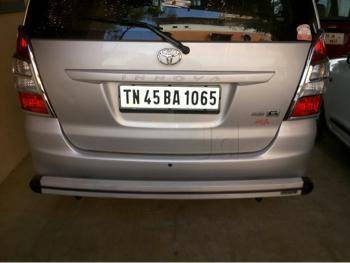

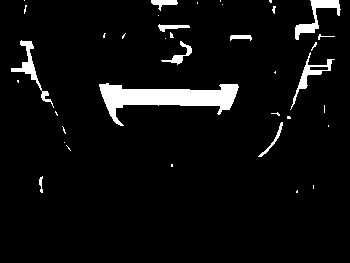

CLEANING PLATE. . .


Detected Text :  TH 4500 1065


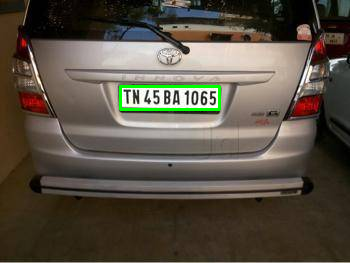

In [24]:
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
import pytesseract as tess
from google.colab.patches import cv2_imshow

def preprocess(img):
	cv2_imshow(img)
	imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
	gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)

	sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)
	#cv2.imshow("Sobel",sobelx)
	#cv2.waitKey(0)
	ret2,threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	#cv2.imshow("Threshold",threshold_img)
	#cv2.waitKey(0)
	return threshold_img

def cleanPlate(plate):
	print("CLEANING PLATE. . .")
	gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
	#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
	#thresh= cv2.dilate(gray, kernel, iterations=1)

	_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
	contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

	if contours:
		areas = [cv2.contourArea(c) for c in contours]
		max_index = np.argmax(areas)

		max_cnt = contours[max_index]
		max_cntArea = areas[max_index]
		x,y,w,h = cv2.boundingRect(max_cnt)

		if not ratioCheck(max_cntArea,w,h):
			return plate,None

		cleaned_final = thresh[y:y+h, x:x+w]
		#cv2.imshow("Function Test",cleaned_final)
		return cleaned_final,[x,y,w,h]

	else:
		return plate,None


def extract_contours(threshold_img):
	element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
	morph_img_threshold = threshold_img.copy()
	cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
	cv2_imshow(morph_img_threshold)
	cv2.waitKey(0)

	contours,hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
	return contours


def ratioCheck(area, width, height):
	ratio = float(width) / float(height)
	if ratio < 1:
		ratio = 1 / ratio

	aspect = 4.7272
	min = 15*aspect*15  # minimum area
	max = 125*aspect*125  # maximum area

	rmin = 3
	rmax = 6

	if (area < min or area > max) or (ratio < rmin or ratio > rmax):
		return False
	return True

def isMaxWhite(plate):
	avg = np.mean(plate)
	if(avg>=115):
		return True
	else:
 		return False

def validateRotationAndRatio(rect):
	(x, y), (width, height), rect_angle = rect

	if(width>height):
		angle = -rect_angle
	else:
		angle = 90 + rect_angle

	if angle>15:
	 	return False

	if height == 0 or width == 0:
		return False

	area = height*width
	if not ratioCheck(area,width,height):
		return False
	else:
		return True



def cleanAndRead(img,contours):
	#count=0
	for i,cnt in enumerate(contours):
		min_rect = cv2.minAreaRect(cnt)

		if validateRotationAndRatio(min_rect):

			x,y,w,h = cv2.boundingRect(cnt)
			plate_img = img[y:y+h,x:x+w]


			if(isMaxWhite(plate_img)):
				#count+=1
				clean_plate, rect = cleanPlate(plate_img)

				if rect:
					x1,y1,w1,h1 = rect
					x,y,w,h = x+x1,y+y1,w1,h1
					cv2_imshow(clean_plate)
					cv2.waitKey(0)
					plate_im = Image.fromarray(clean_plate)
					text = tess.image_to_string(plate_im, lang='eng')
					print("Detected Text : ",text)
					img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
					cv2_imshow(img)
					cv2.waitKey(0)

	#print "No. of final cont : " , count



if __name__ == '__main__':
	print( "DETECTING PLATE . . .")

	#img = cv2.imread("testData/Final.JPG")
	img = cv2.imread("test2.jpg")

	threshold_img = preprocess(img)
	contours= extract_contours(threshold_img)

	#if len(contours)!=0:
		#print len(contours) #Test
		# cv2.drawContours(img, contours, -1, (0,255,0), 1)
		# cv2.imshow("Contours",img)
		# cv2.waitKey(0)


	cleanAndRead(img,contours)

In [15]:
!pip install tesseract

     |████████████████████████████████| 45.6MB 74kB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-cp36-none-any.whl size=45562571 sha256=116f22a5a837ecb7559f16d6e1e8b30ec3682f9dfd36fc940aca9db34d708ff0
  Stored in directory: /root/.cache/pip/wheels/82/1f/d9/24797b123379e4ea9511cf660835468b62dad609634cad2aba
Successfully built tesseract


In [18]:
! apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (28.0 MB/s)
Selecting previously unselecte

In [19]:
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libleptonica-dev
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 2,755 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Fetched 2,755 kB in 0s (18.1 MB/s)
Selecting previously unselected package libleptonica-dev.
(Reading database ... 145160 files and directories currently installed.)
Preparing to unpack .../libleptonica-dev_1.75.3-3_amd64.deb